# Lecture 4 (Part 2): Sequence-to-Sequence Models and Attention

**What you'll learn in this notebook:**

5. Sequence-to-sequence modelling with encoder-decoder RNNs
6. The idea of attention -- letting the decoder "look back" at the encoder

**Task:** We'll build a model that reverses names (with added noise), and visualise how attention learns to focus on the right characters.

### Quick Recap from Part 1

In Part 1, we built an **RNN language model** -- a single RNN that reads a sequence and predicts the next token at each step. This works well for *generation* tasks (e.g., generating names).

But what about tasks where we have an **input sequence** and need to produce a **different output sequence**? For example:
- Machine translation: "hello" -> "bonjour"
- Summarisation: long document -> short summary
- Our task: reversing a string with noise

For this, we need the **encoder-decoder** (seq2seq) framework.

In [1]:
data = open('names.txt').read().splitlines()
data[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [2]:
token_to_index = {tok: i for i, tok in enumerate('abcdefghijklmnopqrstuvwxyz')}
# Start/stop token
token_to_index['[S]'] = 26
# Padding token
token_to_index['[PAD]'] = 27

index_to_token = {i: tok for tok, i in token_to_index.items()}

## 5. Sequence-to-Sequence Modelling

### The Encoder-Decoder Architecture

A seq2seq model uses **two** RNNs:

**Encoder** -- reads the input sequence token by token and builds up a hidden state. The final hidden state $h_T$ is the **context vector**: a fixed-size summary of the entire input.

**Decoder** -- receives the context vector as its initial hidden state and generates the output sequence one token at a time.

$$\text{Encoder: } h_t^{enc} = \text{GRU}(x_t,\ h_{t-1}^{enc})$$

$$\text{Decoder: } h_t^{dec} = \text{GRU}(y_{t-1},\ h_{t-1}^{dec}), \quad h_0^{dec} = h_T^{enc}$$

### Teacher Forcing

During **training**, we feed the decoder the **ground-truth** previous token (not its own prediction). This is called *teacher forcing* and speeds up training. During **generation**, the decoder uses its own predictions since we don't have the ground truth.

## Task: reversing names

Our task will be to reverse a name, e.g.:

    sophia -> aihpos

To make the model learn an additional simple pattern, we'll also add a noise character after each character of the input, e.g.:

    suorpxhziwa -> aihpos

As a spoiler, we'll be able to see the model attending to non-noise characters.

In [4]:
import torch

def build_dataset(data):
    """Build encoder input (X), decoder input (Yin), and decoder target (Yout).
    
    For each name like "sophia":
      - Encoder input X:  s ? o ? p ? h ? i ? a ?   (noise char '?' inserted after each real char)
      - Decoder input Yin:   [S] a i h p o s         (reversed name, shifted right)
      - Decoder target Yout:  a  i h p o s [S]       (reversed name, shifted left)
    
    The noise forces the model to learn selective attention -- it must ignore noise chars.
    """
    X, Yin, Yout = [], [], []
    for item in data:
        # Build encoder input: real char + random noise char, alternating
        x_tokens = []
        for token in item:
            x_tokens.append(token)             # real character (even positions: 0, 2, 4, ...)
            x_tokens.append(random.choice('abcdefghijklmnopqrstuvwxyz'))  # noise (odd positions)
        
        # Decoder target: reversed name, wrapped in [S] tokens
        y_tokens = ['[S]'] + list(reversed(item)) + ['[S]']

        x_indices = [token_to_index[token] for token in x_tokens]
        y_indices = [token_to_index[token] for token in y_tokens]
        X.append(x_indices)
        Yin.append(y_indices[:-1])   # decoder input:  [S] a i h p o s
        Yout.append(y_indices[1:])   # decoder target:  a  i h p o s [S]
    return X, Yin, Yout

# Split into train, dev, test
import random
random.seed(123)
random.shuffle(data)

n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))

X_train, Yin_train, Yout_train = build_dataset(data[:n1])
X_dev, Yin_dev, Yout_dev = build_dataset(data[n1:n2])
X_test, Yin_test, Yout_test = build_dataset(data[n2:])
len(X_train), len(Yin_train), len(Yout_train)

(25626, 25626, 25626)

## 6. The Idea of Attention

### The Bottleneck Problem

In a standard seq2seq model, the encoder must compress the **entire input** into a single fixed-size vector $h_T$. For long sequences, this vector simply cannot carry all the information the decoder needs.

### The Fix: Let the Decoder Look Back

**Attention** allows the decoder to "look at" all encoder hidden states $h_1, h_2, ..., h_T$ at every decoding step, instead of relying only on $h_T$.

### How It Works: Query, Key, Value

Think of it like a search:

| Concept | Analogy | In our model |
|---------|---------|-------------|
| **Query** $q$ | "What am I looking for?" | Current decoder hidden state $s_t$ |
| **Keys** $k_i$ | "What's available?" | Each encoder hidden state $h_i$ |
| **Values** $v_i$ | "What's the content?" | Same as keys ($h_i$) |

**Step 1** -- Score each key against the query (dot product):
$$\text{score}_i = q^T \cdot k_i$$

**Step 2** -- Normalise scores into a probability distribution:
$$\alpha = \text{softmax}(\text{scores})$$

**Step 3** -- Weighted sum of values gives the **context vector**:
$$c_t = \sum_i \alpha_i \cdot v_i$$

The decoder then uses **both** its own hidden state and this context vector to predict the next token.

### Walking Through Attention Step by Step

Let's compute attention manually with toy tensors. We have:
- **B=2** examples in a batch
- **Tx=3** encoder time steps (3 keys/values)
- **D=6** dimensional hidden states
- **1** decoder query per example

The steps are:
1. Compute dot products between query and each key
2. Apply softmax to get weights (they sum to 1)
3. Weighted sum of values gives the context vector

In [6]:
B = 2    # batch size
Tx = 3   # encoder sequence length (number of keys/values)
D = 6    # hidden dimension

# Step 0: Create toy data
keys = torch.randn((B, Tx, D))    # encoder hidden states: shape (B, Tx, D)
values = keys                      # in basic attention, values = keys

query = torch.randn((B, 1, D))    # decoder hidden state at one step: shape (B, 1, D)

# Step 1: Compute dot-product scores between query and each key
# keys: (B, Tx, D)  x  query^T: (B, D, 1)  ->  scores: (B, Tx, 1)
dot = torch.bmm(keys, query.transpose(1, 2))
print("Raw scores shape:", dot.shape)
print("Raw scores:\n", dot.squeeze())

# Step 2: Normalise with softmax -> attention weights (sum to 1)
weights = torch.softmax(dot, dim=1)
print("\nAttention weights:\n", weights.squeeze())

# Step 3: Weighted sum of values -> context vector
# weights: (B, Tx, 1) * values: (B, Tx, D) -> sum over Tx -> (B, D)
out = torch.sum(weights * values, dim=1)
print("\nContext vector shape:", out.shape)
out


Raw scores shape: torch.Size([2, 3, 1])
Raw scores:
 tensor([[ 0.7245,  0.0217,  1.7451],
        [ 2.0641, -3.9404, -0.2415]])

Attention weights:
 tensor([[0.2342, 0.1160, 0.6499],
        [0.9073, 0.0022, 0.0905]])

Context vector shape: torch.Size([2, 6])


tensor([[-0.0474,  0.4274,  0.3295,  0.5620, -1.1502,  0.6668],
        [-0.6496,  1.0876, -1.1591,  0.1492,  1.0991,  0.4112]])

In [7]:
weights.sum(dim=1)

tensor([[1.],
        [1.]])

### Putting It All Together: Encoder-Decoder with Attention

Our full model has these components:

1. **Shared embedding** -- maps token indices to vectors (shared between encoder and decoder)
2. **Encoder GRU** -- processes input sequence, outputs all hidden states $H_{enc}$
3. **Decoder GRU** -- generates output sequence, initialised with the encoder's last hidden state
4. **DotAttention** -- at each decoder step, computes a context vector from all encoder states
5. **Output layer** -- takes `[decoder hidden state; context vector]` and projects to vocabulary logits

During **generation** (inference), we decode one token at a time using **greedy decoding** (always pick the highest-probability token).

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class DotAttention(nn.Module):
    def __init__(self):
        super(DotAttention, self).__init__()
        
    def forward(self, query, keys, values):
        # query: Decoder hidden state at current step (B, 1, D)
        # keys: All Encoder hidden states (B, Tx, D)
        # values: All Encoder hidden states (B, Tx, D)
        
        # 1. Calculate Attention Scores
        # Dot product between query and keys: (B, 1, D) x (B, D, Tx) -> (B, 1, Tx)
        dot = torch.bmm(keys, query.transpose(1, 2)) 
        
        # 2. Calculate Attention Weights (Probability distribution)
        # Softmax over the sequence dimension (dim=1)
        weights = torch.softmax(dot, dim=1)
        
        # 3. Calculate Context Vector (Weighted sum of values)
        # (B, 1, Tx) x (B, Tx, D) -> (B, 1, D)
        out = torch.bmm(weights.transpose(1, 2), values)
        
        return out, weights


class EncoderDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(EncoderDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.decoder = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.attention = DotAttention()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size*2, vocab_size)
        
    def forward(self, X, Yin):
        # Encode
        X_embed = self.embed(X)
        Henc, henc_last = self.encoder(X_embed)
        
        # Decode
        Yin_embed = self.embed(Yin)
        Hdec, _ = self.decoder(Yin_embed, henc_last)
        
        # Attention
        query = self.query(Hdec)
        context, _ = self.attention(query, Henc, Henc)
        
        # Combine
        out = torch.cat([Hdec, context], dim=2)
        out = self.out(out)
        return out
    
    def generate(self, X, max_len=20):
        # Encode
        X_embed = self.embed(X)
        Henc, h = self.encoder(X_embed)
        # Initialize with start token
        token = torch.tensor([[token_to_index['[S]']]]).to(X.device)
        result = []
        attentions = []
        for i in range(max_len):
            token_embed = self.embed(token)
            Hdec, h = self.decoder(token_embed, h)

            # Attention
            query = self.query(Hdec)
            context, scores = self.attention(query, Henc, Henc)

            # Output
            out = torch.cat([Hdec, context], dim=2)
            out = self.out(out)

            # Select next token (greedy decoding)
            token = torch.argmax(out, dim=2)
            result.append(token.item())
            attentions.append(scores)

            if token[0].item() == token_to_index['[S]']:
                break

        return result, attentions

### Sidenote: Batching and Padding for Encoder-Decoder

In a seq2seq model, we have **three** sequences per example that may differ in length:
- **X** (encoder input) -- varies because names have different lengths (plus noise doubles it)
- **Yin** (decoder input) -- varies because reversed names have different lengths
- **Yout** (decoder target) -- same length as Yin

We pad each of the three separately to the maximum length within the batch. As before, we use `ignore_index` in the loss to skip `[PAD]` positions.

In [9]:
def pad_batch(X, Yin, Yout):
    max_len_x = max(len(x) for x in X)
    max_len_y = max(len(y) for y in Yin)
    X_pad = torch.tensor([x + [token_to_index['[PAD]']] * (max_len_x - len(x)) for x in X])
    Yin_pad = torch.tensor([y + [token_to_index['[PAD]']] * (max_len_y - len(y)) for y in Yin])
    Yout_pad = torch.tensor([y + [token_to_index['[PAD]']] * (max_len_y - len(y)) for y in Yout])
    return X_pad, Yin_pad, Yout_pad

xp, yip, yop = pad_batch(X_train[:3], Yin_train[:3], Yout_train[:3])
xp, yip, yop

(tensor([[11, 20, 20, 15,  0, 21, 13, 23, 13, 23, 27, 27],
         [18, 17,  7,  1,  0, 14,  8, 11, 13, 21, 27, 27],
         [17, 22, 20,  5, 15, 22,  4, 22, 17,  4, 19,  7]]),
 tensor([[26, 13, 13,  0, 20, 11, 27],
         [26, 13,  8,  0,  7, 18, 27],
         [26, 19, 17,  4, 15, 20, 17]]),
 tensor([[13, 13,  0, 20, 11, 26, 27],
         [13,  8,  0,  7, 18, 26, 27],
         [19, 17,  4, 15, 20, 17, 26]]))

### Training the Encoder-Decoder

The training loop is similar to Part 1, with one addition: we use a **cosine learning rate schedule** that gradually reduces the learning rate for smoother convergence.

Note: During training, the decoder receives the **ground-truth** previous token at each step (teacher forcing). This means the decoder never sees its own mistakes during training -- it always gets the correct input.

In [10]:
import torch.optim as optim

model = EncoderDecoder(vocab_size=len(token_to_index), embed_size=32, hidden_size=32)
# Count model parameters
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 8

# Loss function and optimizer
# NOTE: We ignore the loss whenever the target token is a padding token
criterion = nn.CrossEntropyLoss(ignore_index=token_to_index['[PAD]'])

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate schedule (cosine)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# Training loop
for epoch in range(num_epochs):
    # Reshuffle the data
    perm = torch.randperm(len(X_train))
    X_train = [X_train[i] for i in perm]
    Yin_train = [Yin_train[i] for i in perm]
    Yout_train = [Yout_train[i] for i in perm]
    
    model.train()
    total_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        Yin_batch = Yin_train[i:i+batch_size]
        Yout_batch = Yout_train[i:i+batch_size]

        # Pad batch
        X_batch, Yin_batch, Yout_batch = pad_batch(X_batch, Yin_batch, Yout_batch)

        # Forward
        outputs = model(X_batch, Yin_batch)
        outputs = outputs.view(-1, len(token_to_index)) # [batch_size * seq_len, vocab_size]
        Y_batch = Yout_batch.view(-1)
        loss = criterion(outputs, Y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        total_loss += loss.item()
        
    # Scheduler step
    scheduler.step()

    avg_loss = total_loss / (len(X_train) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Evaluate validation loss
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for i in range(0, len(X_dev), batch_size):
            X_batch = X_dev[i:i+batch_size]
            Yin_batch = Yin_dev[i:i+batch_size]
            Yout_batch = Yout_dev[i:i+batch_size]
            # Pad batch 
            X_batch, Yin_batch, Yout_batch = pad_batch(X_batch, Yin_batch, Yout_batch)
            outputs = model(X_batch, Yin_batch)

            outputs = outputs.view(-1, len(token_to_index))
            Y_batch = Yout_batch.view(-1)
            loss = criterion(outputs, Y_batch)

            eval_loss += loss.item()
    avg_eval_loss = eval_loss / (len(X_dev) // batch_size)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_eval_loss:.4f}')


Model parameters: 16444
Epoch [1/10], Loss: 0.9612
Epoch [1/10], Validation Loss: 0.2092
Epoch [2/10], Loss: 0.0729
Epoch [2/10], Validation Loss: 0.0374
Epoch [3/10], Loss: 0.0305
Epoch [3/10], Validation Loss: 0.0147
Epoch [4/10], Loss: 0.0197
Epoch [4/10], Validation Loss: 0.0104
Epoch [5/10], Loss: 0.0107
Epoch [5/10], Validation Loss: 0.0153
Epoch [6/10], Loss: 0.0076
Epoch [6/10], Validation Loss: 0.0043
Epoch [7/10], Loss: 0.0035
Epoch [7/10], Validation Loss: 0.0016
Epoch [8/10], Loss: 0.0015
Epoch [8/10], Validation Loss: 0.0072
Epoch [9/10], Loss: 0.0008
Epoch [9/10], Validation Loss: 0.0011
Epoch [10/10], Loss: 0.0005
Epoch [10/10], Validation Loss: 0.0008


### Generation (Inference)

At test time, we use the `generate` method which:
1. Encodes the full input sequence
2. Starts the decoder with the `[S]` token and the encoder's final hidden state
3. At each step: runs the decoder, applies attention, picks the highest-scoring token (**greedy decoding**)
4. Feeds the predicted token back as the next input
5. Stops when `[S]` is generated or max length is reached

In [11]:
# Generate
model.eval()
with torch.no_grad():
    for i in range(10):
        x = torch.tensor([X_test[i]])
        y, _ = model.generate(x)
        y = ''.join([index_to_token[i] for i in y])
        # Remove [S] from the end of y
        y = y.split('[S]')[0]

        # Print original and generated names
        print(data[n2+i], end=' -> ')
        print(y)
        # Check if it was reversed correctly
        correct = data[n2+i][::-1] == y
        print('Correct' if correct else 'Incorrect')
        print()

kaidence -> ecnediak
Correct

eretria -> airtere
Correct

nadiah -> haidan
Correct

price -> ecirp
Correct

naja -> ajan
Correct

masaki -> ikasam
Correct

rook -> koor
Correct

yanitza -> aztinay
Correct

ozzie -> eizzo
Correct

lazzaro -> orazzal
Correct



### Sidenote: Visualising Attention

The attention heatmap shows which **input tokens** (y-axis) the model focuses on when producing each **output token** (x-axis).

**How to read it:**
- Each column is one decoder step (one output character)
- Darker cells = higher attention weight = the model is "looking" at that input position
- For our reversal task, we expect a **reverse diagonal** pattern: the first output token should attend to the last input token, etc.
- **Red labels** on the y-axis are noise characters. A good model should mostly **ignore** them (low attention weights on odd positions)

In [12]:
# Visualize attention for an example

import matplotlib.pyplot as plt

# Random example index
index = torch.randint(0, len(X_test), (1,)).item()

model.eval()
with torch.no_grad():
    x = torch.tensor([X_test[index]])
    y, attentions = model.generate(x)

    # Print original and generated names
    y = ''.join([index_to_token[i] for i in y])
    # Remove [S] from the end of y
    y = y.split('[S]')[0]
    print(data[n2+index], end=' -> ')
    print(y)

attentions = torch.cat(attentions, dim=2).squeeze().cpu().numpy()

kemani -> inamek


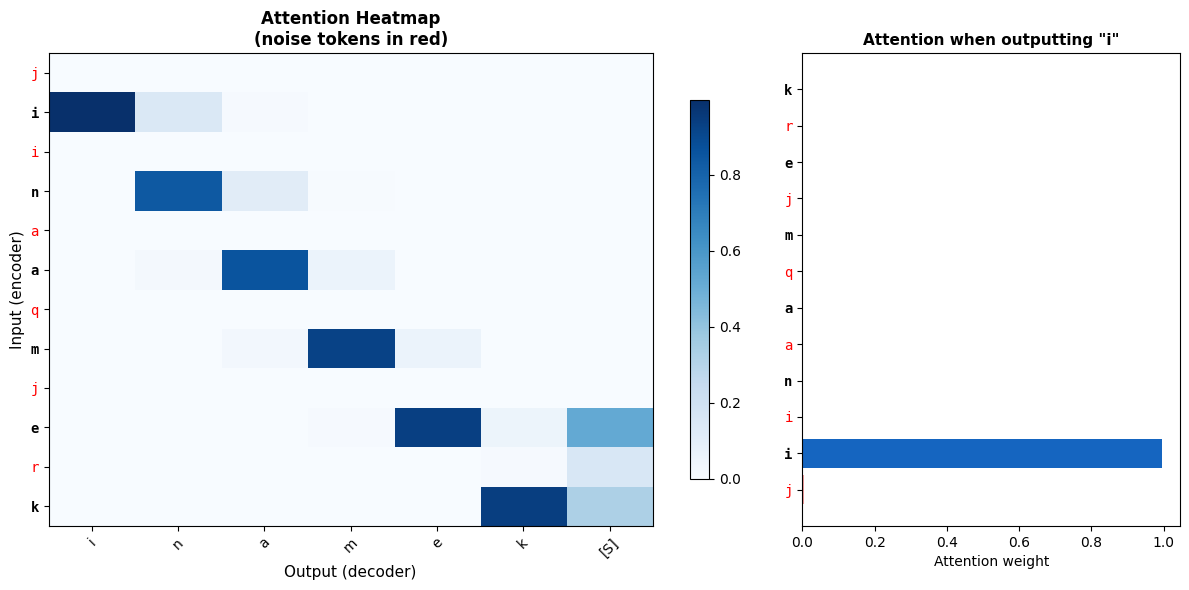

In [13]:
xtext = X_test[index]
xtext = [index_to_token[i] for i in xtext]
ytext = list(y) + ['[S]']

fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

# --- Left: Full attention heatmap ---
ax = axes[0]
im = ax.imshow(attentions, cmap='Blues', aspect='auto')
ax.invert_yaxis()
ax.set_xticks(range(len(ytext)))
ax.set_xticklabels(ytext, rotation=45, fontsize=10)
ax.set_yticks(range(len(xtext)))
ax.set_yticklabels(xtext, rotation=0, fontsize=10, fontfamily='monospace')

# Colour noise tokens red on y-axis
for i, label in enumerate(ax.get_yticklabels()):
    if i % 2 == 0:
        label.set_color('black')
        label.set_fontweight('bold')
    else:
        label.set_color('red')

ax.set_ylabel('Input (encoder)', fontsize=11)
ax.set_xlabel('Output (decoder)', fontsize=11)
ax.set_title('Attention Heatmap\n(noise tokens in red)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=ax, shrink=0.8)

# --- Right: Bar chart for the first output token ---
step_idx = 0  # which decoder step to visualise
ax2 = axes[1]
bars = ax2.barh(range(len(xtext)), attentions[:, step_idx], color=['#1565C0' if i % 2 == 0 else '#EF9A9A' for i in range(len(xtext))])
ax2.set_yticks(range(len(xtext)))
ax2.set_yticklabels(xtext, fontfamily='monospace', fontsize=10)
ax2.invert_yaxis()
ax2.set_xlabel('Attention weight', fontsize=10)
ax2.set_title(f'Attention when outputting "{ytext[step_idx]}"', fontsize=11, fontweight='bold')

# Colour noise labels red
for i, label in enumerate(ax2.get_yticklabels()):
    if i % 2 == 0:
        label.set_color('black')
        label.set_fontweight('bold')
    else:
        label.set_color('red')

plt.tight_layout()
plt.savefig('attention.png', dpi=300)
plt.show()